# Crusial Information
Before you run this Jupyter Notebook, please make sure that you have installed in your system those packages:
1. python     : 3.6.4
2. numpy      : 1.15.4
3. torchtext  : 0.3.1
4. pandas     : 0.25.3
5. pytorch    : 0.4.1
6. matplotlib : 2.2.3
7. seaborn    : 0.9.0

# Import of the core modules and datasets

In [1]:
import torch
import time
import random
import pandas as pd
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

# Generation of bi-grams

In [2]:
def bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [3]:
TEXT = data.Field(tokenize='spacy', preprocessing=bigrams)
LABEL = data.LabelField(dtype=torch.float)

c:\users\tosodoulis\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\tosodoulis\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)
c:\users\tosodoulis\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\tosodoulis\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **

# Create the splits of the IMDB dataset

In [4]:
SEED = 1234

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

# Build the vocabulary and load the pre-trained word embeddings

In [5]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.840B.300d")
LABEL.build_vocab(train_data)

# Create the iterators for the batches

In [6]:
BATCH_SIZE = 64

device = torch.device('cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device)

## Model design

In [7]:
class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, x):
          
        embedded = self.embedding(x)              
        embedded = embedded.permute(1, 0, 2)        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)        
        return self.fc(pooled)

## Model initialization

In [8]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
OUTPUT_DIM = 1

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)

In [9]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.1616, -0.0865, -0.0549,  ...,  0.0798,  0.0682, -0.2743],
        [-0.7620,  0.1726, -0.1530,  ..., -0.4460, -0.2055, -0.2979],
        [-0.1739,  0.1373, -0.2823,  ...,  0.2134,  0.1351, -0.7423]])

In [10]:
optimizer = optim.Adam(model.parameters())

In [11]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [12]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

 ## Train function

In [13]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Evaluation function

In [14]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Training of the model

In [15]:
N_EPOCHS = 6
t1 = time.time()
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
t2 = time.time()

| Epoch: 01 | Train Loss: 0.680 | Train Acc: 59.84% | Val. Loss: 0.567 | Val. Acc: 74.63% |
| Epoch: 02 | Train Loss: 0.593 | Train Acc: 76.51% | Val. Loss: 0.452 | Val. Acc: 79.84% |
| Epoch: 03 | Train Loss: 0.478 | Train Acc: 83.37% | Val. Loss: 0.396 | Val. Acc: 84.69% |
| Epoch: 04 | Train Loss: 0.389 | Train Acc: 87.52% | Val. Loss: 0.391 | Val. Acc: 86.96% |
| Epoch: 05 | Train Loss: 0.329 | Train Acc: 89.66% | Val. Loss: 0.409 | Val. Acc: 87.94% |
| Epoch: 06 | Train Loss: 0.288 | Train Acc: 91.01% | Val. Loss: 0.438 | Val. Acc: 88.88% |


## Time taken for the training

In [16]:
time_of_training = (t2-t1)/60
print(f'The time taken for training is: {time_of_training:.2f} minutes')

The time taken for training is: 26.67 minutes


## Test accuracy

In [17]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 0.452 | Test Acc: 88.13% |


# User input and sentiment calculation

In [18]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

# Testing the model

### Function to get the average of the total sentiments

In [19]:
def evaluate_reviews(some_review):
    total = 0
    avg = 0
    length = len(some_review)
    for i in some_review:
        total = total + predict_sentiment(i) 
    avg = total/length
    return avg    

### Function for the creation of the histograms

In [20]:
def tryplot(some_review):
    new_list = []
    for i in some_review:
        new_list.append(predict_sentiment(i))    
    return new_list 

# Import the CSVs

In [21]:
the_becoming            = pd.read_csv("reviews/the_becoming.csv",usecols=[5])
middle_earth            = pd.read_csv("reviews/middle_earth.csv",usecols=[5])
clue_game               = pd.read_csv("reviews/clue_game.csv",usecols=[5])
oculus_vr               = pd.read_csv("reviews/oculus_vr.csv",usecols=[5])
toshiba_hdd             = pd.read_csv("reviews/toshiba_hdd.csv",usecols=[5])
samsung_gear_s3         = pd.read_csv("reviews/samsung_gear_s3.csv",usecols=[5])
sony_1000               = pd.read_csv("reviews/sony-1000.csv",usecols=[5])
sandisk_microsd         = pd.read_csv("reviews/sandisk-microsd.csv",usecols=[5])
book_kids_cancer        = pd.read_csv("reviews/book_kids_cancer.csv",usecols=[5])
the_queen_james_bible   = pd.read_csv("reviews/the_queen_james_bible.csv",usecols=[5])
wjzxtek                 = pd.read_csv("reviews/wjzxtek_universal_waterproof_case.csv",usecols=[5])
winstal                 = pd.read_csv("reviews/winstal_lawn_aerator.csv",usecols=[5])
bose                    = pd.read_csv("reviews/bose_quiet_35.csv",usecols=[5])
xbox_controller         = pd.read_csv("reviews/xbox_controller.csv",usecols=[5])
read_dead               = pd.read_csv("reviews/red_dead.csv",usecols=[5])
wii                     = pd.read_csv("reviews/wii.csv",usecols=[5])
logitech_g920           = pd.read_csv("reviews/logitech_g920.csv",usecols=[5])
wilson                  = pd.read_csv("reviews/wilson.csv",usecols=[5])
ipad_cover              = pd.read_csv("reviews/jetech_ipad_cover.csv",usecols=[5])
vector_robot            = pd.read_csv("reviews/vector_robot.csv",usecols=[5])

# List the columns

In [22]:
the_becoming_reviews                = the_becoming["content"].tolist()
middle_earth_reviews                = middle_earth["content"].tolist()
clue_game_reviews                   = clue_game["content"].tolist()
oculus_vr_reviews                   = oculus_vr["content"].tolist()
toshiba_hdd_reviews                 = toshiba_hdd["content"].tolist()
sony_1000_reviews                   = sony_1000["content"].tolist()
samsung_gear_s3_reviews             = samsung_gear_s3["content"].tolist()
sandisk_microsd_reviews             = sandisk_microsd["content"].tolist()
book_kids_cancer_reviews            = book_kids_cancer["content"].tolist()
the_queen_james_bible_reviews       = the_queen_james_bible["content"].tolist()
wjzxtek_reviews                     = wjzxtek["content"].tolist()
winstal_reviews                     = winstal["content"].tolist()
bose_reviews                        = bose["content"].tolist()
xbox_controller_reviews             = xbox_controller["content"].tolist()
read_dead_reviews                   = read_dead["content"].tolist()
wii_reviews                         = wii["content"].tolist()
logitech_g920_reviews               = logitech_g920["content"].tolist()
wilson_reviews                      = wilson["content"].tolist()
ipad_cover_reviews                  = ipad_cover["content"].tolist()
vector_robot_reviews                = vector_robot["content"].tolist()

# Evaluation of Reviews 

In [23]:
the_becoming_eval          = evaluate_reviews(the_becoming_reviews)
middle_earth_eval          = evaluate_reviews(middle_earth_reviews)
clue_game_eval             = evaluate_reviews(clue_game_reviews)
oculus_vr_eval             = evaluate_reviews(oculus_vr_reviews)
toshiba_hdd_eval           = evaluate_reviews(toshiba_hdd_reviews)
samsung_gear_s3_eval       = evaluate_reviews(samsung_gear_s3_reviews)
sony_1000_eval             = evaluate_reviews(sony_1000_reviews)
sandisk_microsd_eval       = evaluate_reviews(sandisk_microsd_reviews)
book_kids_cancer_eval      = evaluate_reviews(book_kids_cancer_reviews)
the_queen_james_bible_eval = evaluate_reviews(the_queen_james_bible_reviews)
wjzxtek_eval               = evaluate_reviews(wjzxtek_reviews)
winstal_eval               = evaluate_reviews(winstal_reviews)
bose_eval                  = evaluate_reviews(bose_reviews)
xbox_controller_eval       = evaluate_reviews(xbox_controller_reviews)
read_dead_eval             = evaluate_reviews(read_dead_reviews)
wii_eval                   = evaluate_reviews(wii_reviews)
logitech_g920_eval         = evaluate_reviews(logitech_g920_reviews)
wilson_eval                = evaluate_reviews(wilson_reviews)
ipad_cover_eval            = evaluate_reviews(ipad_cover_reviews)
vector_robot_eval          = evaluate_reviews(vector_robot_reviews)

# Results

In [24]:
print(f'The Becoming evaluation                            : {the_becoming_eval*100:.2f}%')
print(f'Middle Earth DVD set evaluation                    : {middle_earth_eval*100:.2f}%')
print(f'Clue Board game evaluation                         : {clue_game_eval*100:.2f}%')
print(f'Oculus VR evaluation                               : {oculus_vr_eval*100:.2f}%')
print(f'Toshiba HDD evaluation                             : {toshiba_hdd_eval*100:.2f}%')
print(f'Samsung Gear S3 evaluation                         : {samsung_gear_s3_eval*100:.2f}%')
print(f'Sony WH‑1000XM3  evaluation                        : {sony_1000_eval*100:.2f}%')
print(f'SanDisk MicroSDXC evaluation                       : {sandisk_microsd_eval*100:.2f}%')
print(f'I Wish My Kids Had Cancer evaluation               : {book_kids_cancer_eval*100:.2f}%')
print(f'The Queen James Bible evaluation                   : {the_queen_james_bible_eval*100:.2f}%')
print(f'WJZXTEK Universal Waterproof Case evaluation       : {wjzxtek_eval*100:.2f}%')
print(f'Wistar Lawn Aerator Shoes Metal Buckles evaluation : {winstal_eval*100:.2f}%')
print(f'Bose QuietComfort 35 II evaluation                 : {bose_eval*100:.2f}%')
print(f'Xbox Wireless Controller - Black evaluation        : {xbox_controller_eval*100:.2f}%')
print(f'Red Dead Redemption 2 - PlayStation 4 evaluation   : {read_dead_eval*100:.2f}%')
print(f'Wii evaluation                                     : {wii_eval*100:.2f}%')
print(f'Logitech G920 Dual-Motor evaluation                : {logitech_g920_eval*100:.2f}%')
print(f'Wilson Killer Crossover Basketball evaluation      : {wilson_eval*100:.2f}%')
print(f'JETech Case for Apple iPad Air evaluation          : {ipad_cover_eval*100:.2f}%')
print(f'Vector Robot by Anki evaluation                    : {vector_robot_eval*100:.2f}%')

The Becoming evaluation                            : 14.25%
Middle Earth DVD set evaluation                    : 44.70%
Clue Board game evaluation                         : 81.19%
Oculus VR evaluation                               : 81.83%
Toshiba HDD evaluation                             : 69.62%
Samsung Gear S3 evaluation                         : 80.67%
Sony WH‑1000XM3  evaluation                        : 75.02%
SanDisk MicroSDXC evaluation                       : 75.12%
I Wish My Kids Had Cancer evaluation               : 30.33%
The Queen James Bible evaluation                   : 33.11%
WJZXTEK Universal Waterproof Case evaluation       : 78.22%
Wistar Lawn Aerator Shoes Metal Buckles evaluation : 51.17%
Bose QuietComfort 35 II evaluation                 : 76.18%
Xbox Wireless Controller - Black evaluation        : 69.08%
Red Dead Redemption 2 - PlayStation 4 evaluation   : 78.14%
Wii evaluation                                     : 86.45%
Logitech G920 Dual-Motor evaluation     

# Histograms 

In [25]:
plot1 = tryplot(the_becoming_reviews)
plot2 = tryplot(middle_earth_reviews)
plot3 = tryplot(clue_game_reviews)
plot4 = tryplot(oculus_vr_reviews)
plot5 = tryplot(toshiba_hdd_reviews)
plot6 = tryplot(sony_1000_reviews)
plot7 = tryplot(samsung_gear_s3_reviews)
plot8 = tryplot(sandisk_microsd_reviews)
plot9 = tryplot(book_kids_cancer_reviews)
plot10 = tryplot(the_queen_james_bible_reviews)
plot11 = tryplot(wjzxtek_reviews)
plot12 = tryplot(winstal_reviews)
plot13 = tryplot(bose_reviews)
plot14 = tryplot(xbox_controller_reviews)
plot15 = tryplot(read_dead_reviews)
plot16 = tryplot(wii_reviews)
plot17 = tryplot(logitech_g920_reviews)
plot18 = tryplot(wilson_reviews)
plot19 = tryplot(ipad_cover_reviews)
plot20 = tryplot(vector_robot_reviews)

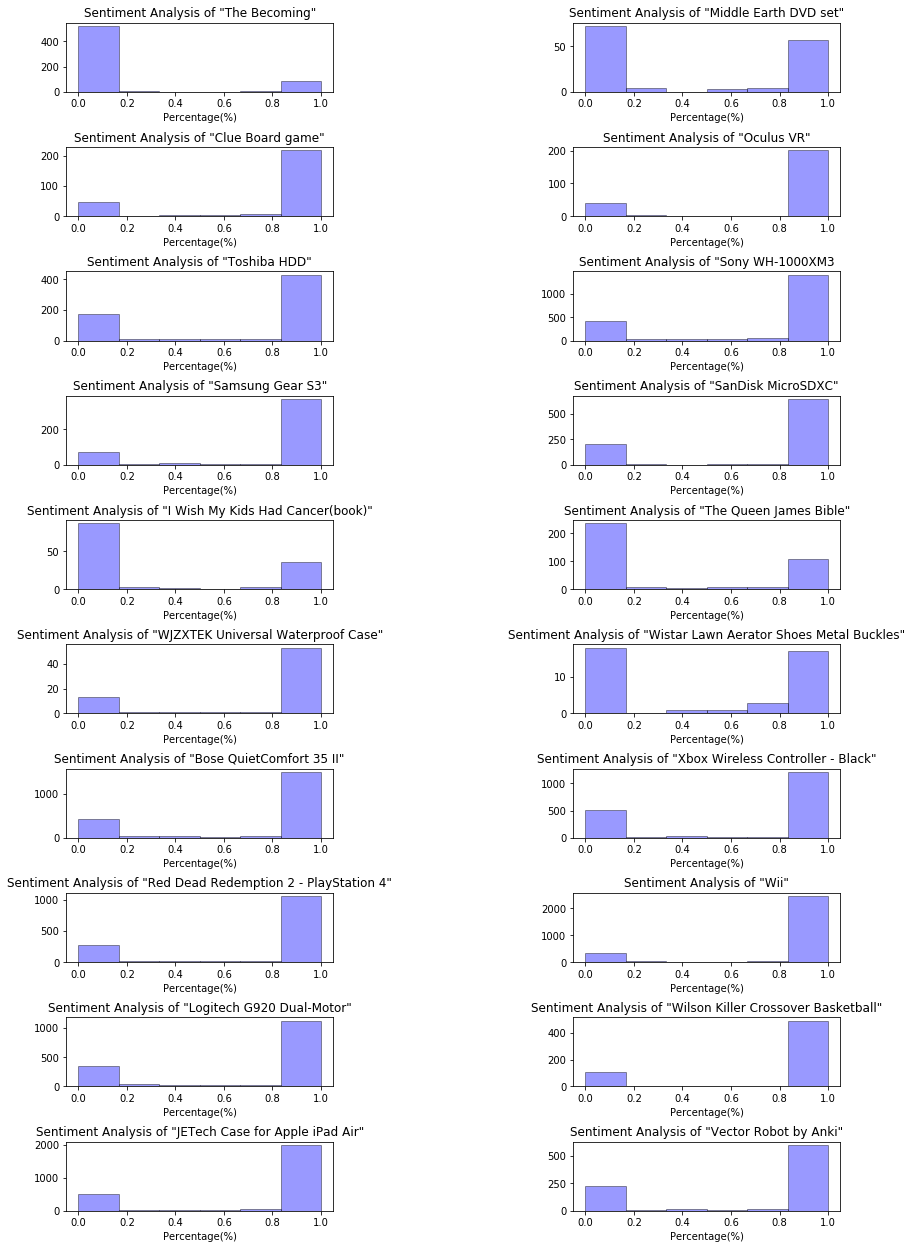

In [26]:
f, axes = plt.subplots(10, 2, figsize=(10,12), sharex=False)
plt.subplots_adjust(hspace = 0.8)
plt.subplots_adjust(top  = 1.5)
plt.subplots_adjust(wspace = 0.9)
plt.subplots_adjust(right  = 1.2)


sns.distplot(plot1, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[0, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "The Becoming"')

sns.distplot(plot2, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[0, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Middle Earth DVD set"')

sns.distplot(plot3, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[1, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Clue Board game"')

sns.distplot(plot4, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[1, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Oculus VR"')

sns.distplot(plot5, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[2, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Toshiba HDD"')

sns.distplot(plot6, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[2, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Sony WH‑1000XM3')

sns.distplot(plot7, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[3, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Samsung Gear S3"')

sns.distplot(plot8, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[3, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "SanDisk MicroSDXC"')

sns.distplot(plot9, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[4, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "I Wish My Kids Had Cancer(book)"')

sns.distplot(plot10, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[4, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "The Queen James Bible"')

sns.distplot(plot11, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[5, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "WJZXTEK Universal Waterproof Case"')

sns.distplot(plot12, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[5, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Wistar Lawn Aerator Shoes Metal Buckles"')

sns.distplot(plot13, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[6, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Bose QuietComfort 35 II"')

sns.distplot(plot14, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[6, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Xbox Wireless Controller - Black"')

sns.distplot(plot15, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[7, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Red Dead Redemption 2 - PlayStation 4"')

sns.distplot(plot16, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[7, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Wii"')

sns.distplot(plot17, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[8, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Logitech G920 Dual-Motor"')

sns.distplot(plot18, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[8, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Wilson Killer Crossover Basketball"')

sns.distplot(plot19, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[9, 0],axlabel="Percentage(%)").set_title('Sentiment Analysis of "JETech Case for Apple iPad Air"')

sns.distplot(plot20, hist=True, kde=False, 
             bins=int(360/60), color = 'blue',
             hist_kws={'edgecolor':'black'},ax=axes[9, 1],axlabel="Percentage(%)").set_title('Sentiment Analysis of "Vector Robot by Anki"')

plt.savefig('histograms.png', bbox_inches='tight')